In [1]:
from dtcs.homogenous_crn.solution import *
from dtcs.homogenous_crn.sym import *
from dtcs.homogenous_crn.xps import *
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import seaborn as sb
import scipy.signal as signal
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
# 1e-6_rt
sols = []
sm = SpeciesManager()

#[535.0 , 532.2 , 530.9 , 530.0 , 531.6 ,  531.6 ,  533.2, 535.0]
#[y1, x2, x3, x4, x53, x54, x6, x7]
y1 = sm.sp('y1', Orbital('1s', 535.0), {0:1.0000})
x2 = sm.sp('x2', Orbital('1s', 532.2), {0:0})
x3 = sm.sp('x3', Orbital('1s', 530.9), {0:0})
x4 = sm.sp('x4', Orbital('1s', 530.0), {0:0.25})
x53 = sm.sp('x53', Orbital('1s', 531.6), {0:0})
x54 = sm.sp('x54', Orbital('1s', 531.6), {0:0})
x6 = sm.sp('x6', Orbital('1s', 533.2), {0:0})
x7 = sm.sp('x7', Orbital('1s', 535.0), {0:0})

multipliers = [0.1, 0.5, 1, 5, 10]
default_rxn_consts = [3.207654, 1.363342, 6.220646, 0.160755, 0.299507, 0.167130, 1.939313, 0.515646, 0.733491, 0.311754, 1.038423, 0.962999, 0.002342,426.922895]

# System Solving
This only needs to be run if a pickled solution is not available.

In [ ]:
# Test code that will be moved into a module
for i in range(len(default_rxn_consts)):
    for j in range(5):
        scaled = list(default_rxn_consts)
        scaled[i] *= multipliers[j]
        
        rsys = RxnSystem(
            Rxn(x4 + y1, x54, scaled[0]), # 0
            Rxn(x3 + y1, x53, scaled[1]), # 1
            Rxn(x54, x3 + x3, scaled[2]), # 2
            Rxn(x3 + x3, x54, scaled[3]), # 3
            Rxn(x53, x2 + x3, scaled[4]), # 4
            Rxn(x54, x2 + x4, scaled[5]), # 5
            Rxn(x2, y1, scaled[6]), # 6
            Rxn(y1, x2, scaled[7]), # 7
            Rxn(x53, y1 + x3, scaled[8]), # 8
            Rxn(x54, x4 + y1, scaled[9]), # 9
            Rxn(x53 + y1, x6, scaled[10]), # 10
            Rxn(x6, x53 + y1, scaled[11]), # 11
            Rxn(x4 + x4, x7, scaled[12]), # 12
            Rxn(x7, x4 + x4, scaled[13]), # 13
            sm
        )
        s = solve(rsys, time=10000)
        sols.append(s)
        print('Solved for ('+str(i)+', '+str(j)+')')
        print(scaled)
        print('\n')

In [ ]:
sols[0].basic_plot()

In [ ]:
import pickle
with open('../nickel_constsv2_noexp.pkl', 'wb') as f:
    pickle.dump(sols, f)

In [ ]:
x = read_new_data('../data/1e-6_rt.txt')
j = 0
for i, s in enumerate(sols):
    print('Const: '+str(int(i / len(multipliers)))+' Multiplier: '+str(multipliers[j]))
    j += 1
    j = j % len(multipliers)
    
    s.set_experimental(x[0])

In [ ]:
import pickle
with open('../nickel_consts.pkl', 'wb') as f:
    pickle.dump(sols, f)

# Analysis

In [3]:
sols = pickle.load(open('../data/nickel_constsv2_noexp.pkl', 'rb'))

In [4]:
x = read_new_data('../data/ag_100e-3_25.txt', be=0)
j = 0
for i, s in enumerate(sols):
    j += 1
    j = j % len(multipliers)
    
    s.set_experimental(x[0])

In [5]:
len(sols[0].distributions)

0

In [6]:
for s in sols:
    s.ignore = [y1]
    s.process(gas_range=(534, 536))

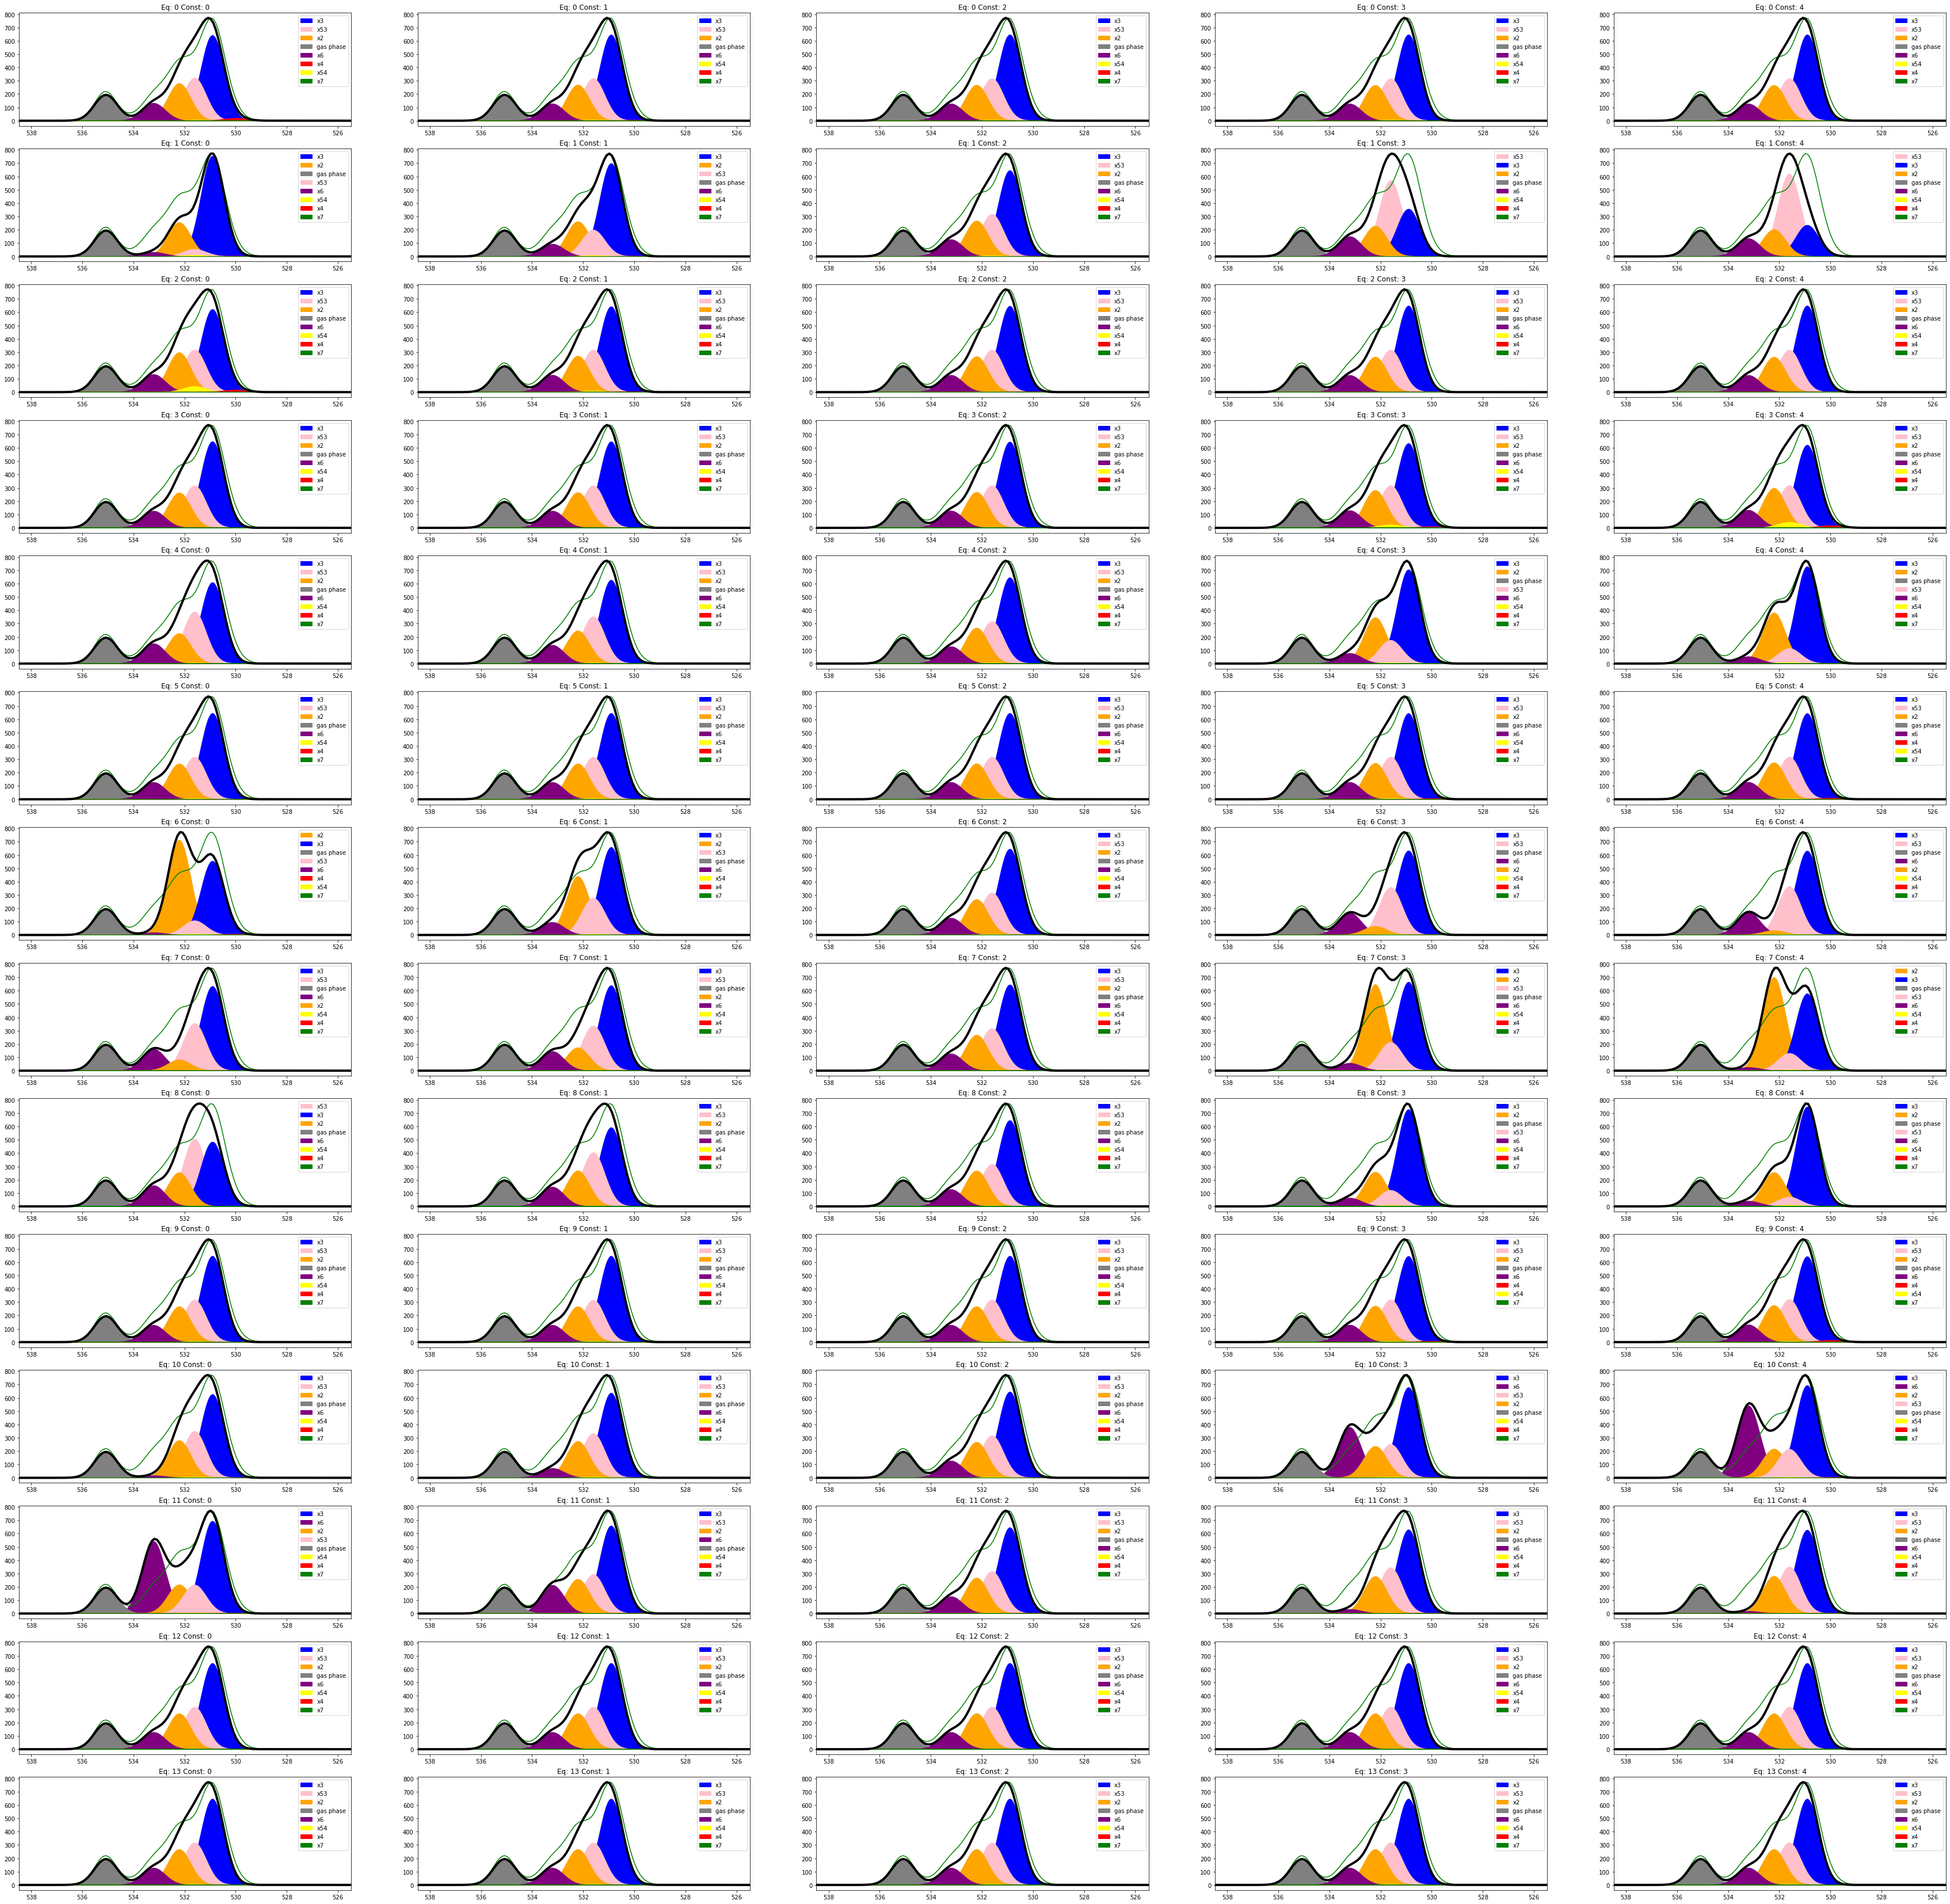

In [7]:
fig, axes = plt.subplots(nrows=14, ncols=5, figsize=(60,60))
for i in range(len(sols)):
    sols[i].plot_gaussian(envelope=True, resample_envelope=True, overlay=True, ax=axes[int(i/5), int(i%5)], title=('Eq: ' + str(int(i/5)) + ' Const: ' + str(i % 5)))
plt.show()

## RMSE Comparison

In [7]:
rmses_list = []
for i in range(len(default_rxn_consts)):
    rmses_list.append([])
    for j in range(5):
        rmses_list[i].append(sols[i*5 + j].rmse())
rmses = pd.DataFrame(rmses_list, columns=['0.1', '0.5', '1', '5', '10'])
rmses

,0.1,0.5,1,5,10
0,40.275773,42.641784,42.992362,43.282368,43.319067
1,72.513773,47.283030,42.992362,87.317342,107.882078
2,44.341603,42.887161,42.992362,43.143746,43.167279
3,43.167293,43.079578,42.992362,43.030317,44.341581
4,48.949548,45.732720,42.992362,40.129335,43.277255
5,43.119693,43.063030,42.992362,42.447304,41.812241
6,87.747280,48.722464,42.992362,66.624933,71.820830
7,63.912973,51.154577,42.992362,77.127005,84.336757
8,68.477018,51.091656,42.992362,59.030438,69.004785
9,43.203941,43.109109,42.992362,42.107587,41.118031


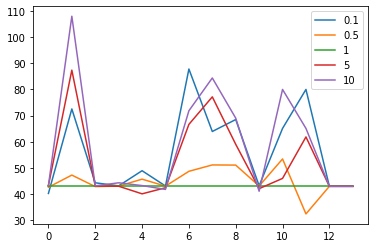

In [8]:
rmses.plot()

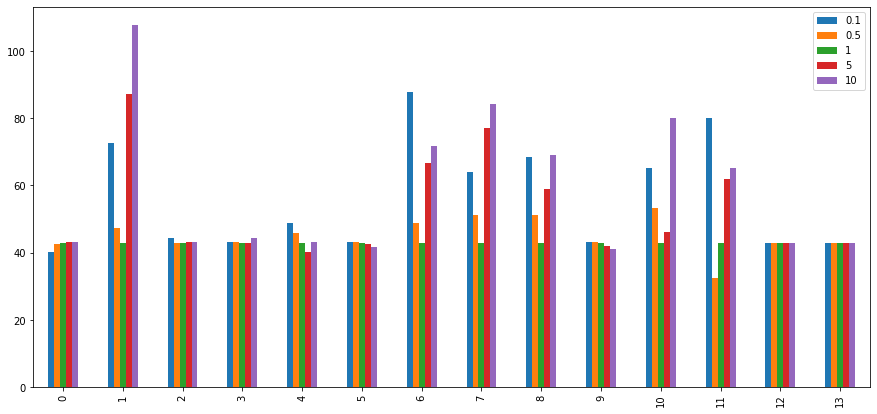

In [9]:
rmses.plot.bar(figsize=(15,7))

In [10]:
rmses_min = rmses.agg(['min', 'idxmin']).T
rmses_min

,min,idxmin
0.1,40.275773,0.0
0.5,32.467351,11.0
1,42.992362,0.0
5,40.129335,4.0
10,41.118031,9.0


0, 0.1


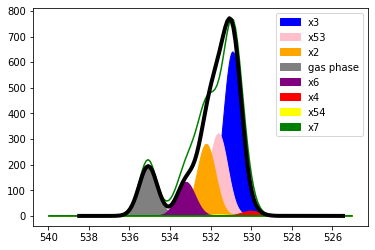

0, 1


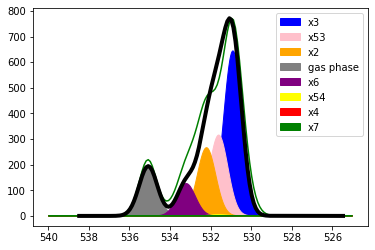

9, 10


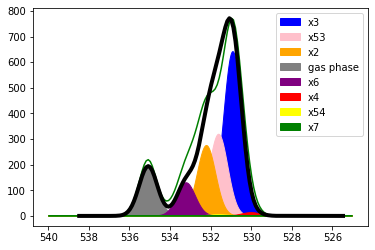

In [11]:
print('0, 0.1')
sols[0].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
print('0, 1')
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
print('9, 10')
sols[49].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)e

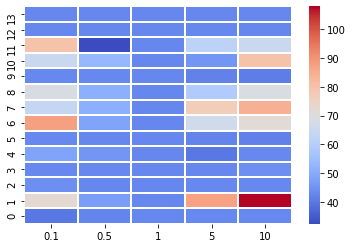

In [12]:
rmse_heatmap = sb.heatmap(rmses, cmap='coolwarm', linewidths=1)
rmse_heatmap.invert_yaxis()

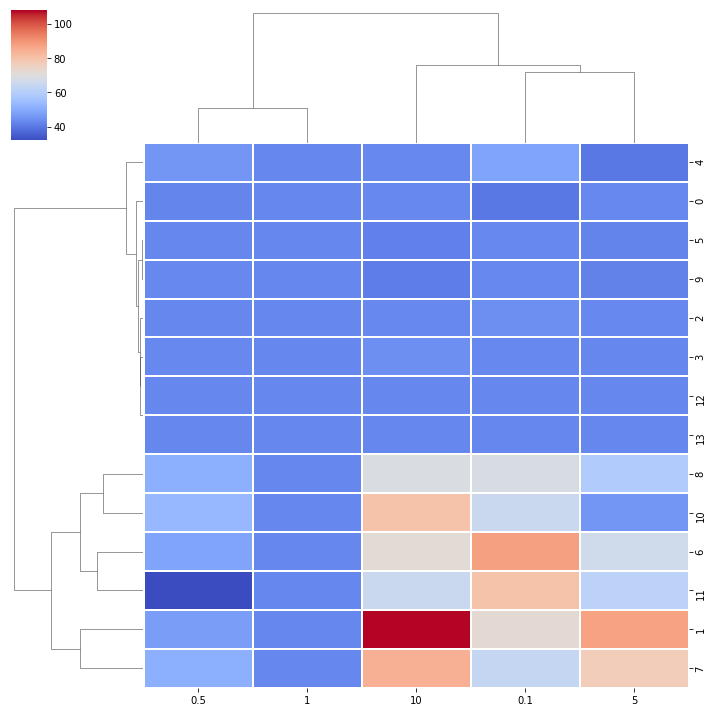

In [13]:
rmse_clustermap = sb.clustermap(rmses, cmap='coolwarm', linewidths=1)

## MAE Comparison

In [14]:
maes_list = []
for i in range(len(default_rxn_consts)):
    maes_list.append([])
    for j in range(5):
        maes_list[i].append(sols[i*5 + j].mae())
maes = pd.DataFrame(maes_list, columns=['0.1', '0.5', '1', '5', '10'])
maes

,0.1,0.5,1,5,10
0,23.699520,25.281726,25.500922,25.678802,25.701133
1,38.743180,25.662987,25.500922,44.584483,53.325521
2,25.672118,25.426608,25.500922,25.564445,25.572685
3,25.572690,25.540195,25.500922,25.432302,25.672108
4,28.202109,26.841357,25.500922,21.139501,23.078016
5,25.576652,25.543010,25.500922,25.168315,24.761077
6,47.802529,28.103598,25.500922,33.017654,34.488242
7,32.218814,28.331725,25.500922,38.904444,45.389554
8,36.192558,28.958249,25.500922,32.158703,37.060057
9,25.630985,25.572938,25.500922,24.937703,24.263778


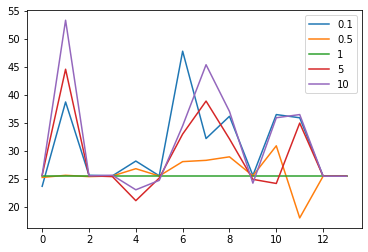

In [15]:
maes.plot()

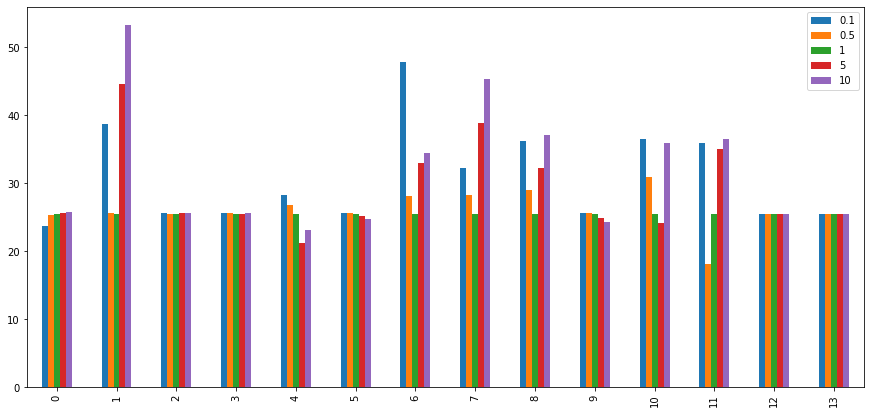

In [16]:
maes.plot.bar(figsize=(15,7))

In [17]:
maes_min = maes.agg(['min', 'idxmin']).T
maes_min

,min,idxmin
0.1,23.699520,0.0
0.5,18.059656,11.0
1,25.500922,0.0
5,21.139501,4.0
10,23.078016,4.0


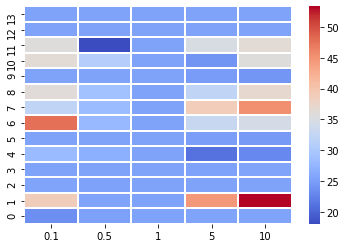

In [18]:
mae_heatmap = sb.heatmap(maes, cmap='coolwarm', linewidths=1)
mae_heatmap.invert_yaxis()

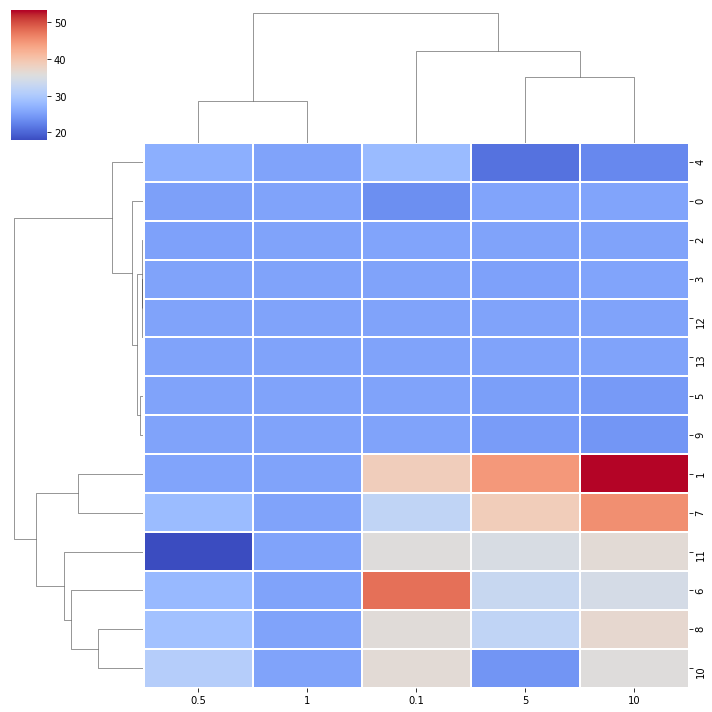

In [19]:
mae_clustermap = sb.clustermap(maes, cmap='coolwarm', linewidths=1)

## MAE Comparison

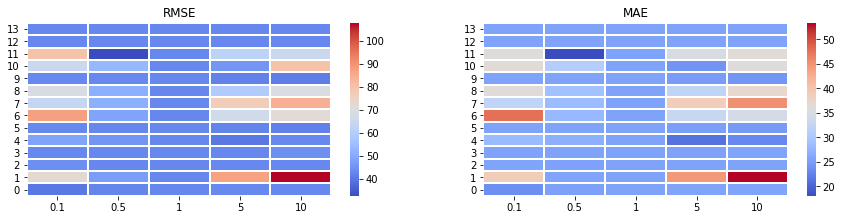

In [20]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

rmse_comp = sb.heatmap(rmses, cmap='coolwarm', linewidths=1, ax=ax1)
mae_comp = sb.heatmap(maes, cmap='coolwarm', linewidths=1, ax=ax2)
rmse_comp.invert_yaxis()
mae_comp.invert_yaxis()

ax1.title.set_text('RMSE')
ax2.title.set_text('MAE')

## Outer Integral Difference Comparison

In [8]:
integrals_list = []
for i in range(len(default_rxn_consts)):
    integrals_list.append([])
    for j in range(5):
        integrals_list[i].append(sols[i*5 + j].integral_diff_outside_experimental())
integral_diffs = pd.DataFrame(integrals_list, columns=['0.1', '0.5', '1', '5', '10'])
integral_diffs

,0.1,0.5,1,5,10
0,-174.704738,-208.766500,-213.337341,-217.050580,-217.517666
1,-505.403937,-330.241179,-213.337341,-278.163926,-406.049360
2,-139.785470,-203.784668,-213.337341,-221.318189,-222.338811
3,-222.338870,-218.288298,-213.337341,-177.507873,-139.785365
4,-196.322998,-204.782966,-213.337341,-271.307958,-302.321995
5,-215.013832,-214.268447,-213.337341,-205.974884,-196.964308
6,-167.010379,-83.082032,-213.337341,-366.781826,-390.620642
7,-353.865735,-284.771566,-213.337341,44.720178,-120.939694
8,-167.964716,-153.870669,-213.337341,-421.278993,-484.291574
9,-216.051925,-214.841041,-213.337341,-201.597689,-187.592401


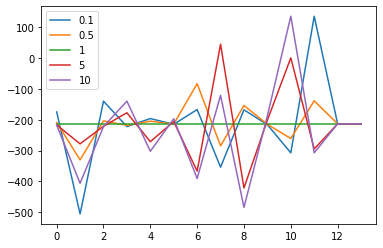

In [9]:
integral_diffs.plot()

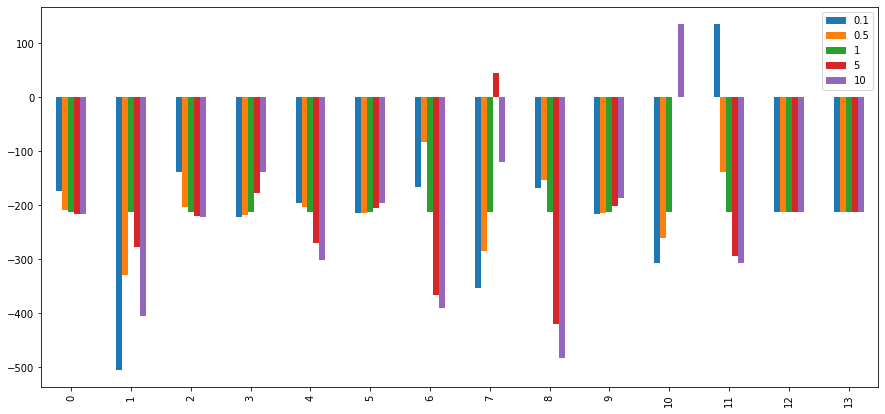

In [10]:
integral_diffs.plot.bar(figsize=(15,7))

In [11]:
integral_diffs_min = integral_diffs.agg(['min', 'idxmin']).T
integral_diffs_min

,min,idxmin
0.1,-505.403937,1.0
0.5,-330.241179,1.0
1,-213.337341,0.0
5,-421.278993,8.0
10,-484.291574,8.0


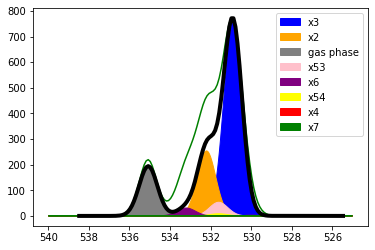

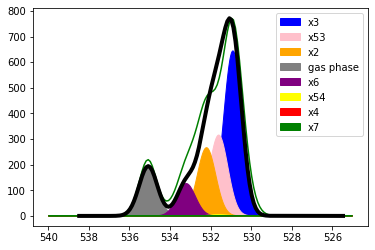

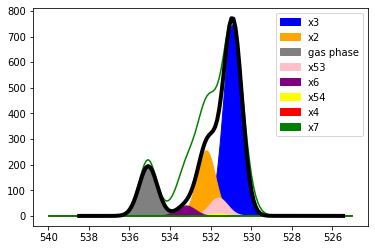

In [13]:
sols[5].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[44].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)

## Inner Integral Difference Comparison

In [14]:
integrals_list = []
for i in range(len(default_rxn_consts)):
    integrals_list.append([])
    for j in range(5):
        integrals_list[i].append(sols[i*5 + j].integral_diff_inside_experimental())
integral_diffs = pd.DataFrame(integrals_list, columns=['0.1', '0.5', '1', '5', '10'])
integral_diffs

,0.1,0.5,1,5,10
0,174.704738,208.766500,213.337341,217.050580,217.517666
1,505.403937,330.241179,213.337341,278.163926,406.049360
2,139.785470,203.784668,213.337341,221.318189,222.338811
3,222.338870,218.288298,213.337341,177.507873,139.785365
4,196.322998,204.782966,213.337341,271.307958,302.321995
5,215.013832,214.268447,213.337341,205.974884,196.964308
6,167.010379,83.082032,213.337341,366.781826,390.620642
7,353.865735,284.771566,213.337341,-44.720178,120.939694
8,167.964716,153.870669,213.337341,421.278993,484.291574
9,216.051925,214.841041,213.337341,201.597689,187.592401


In [15]:
integral_diffs_min = integral_diffs.agg(['min', 'idxmin']).T
integral_diffs_min

,min,idxmin
0.1,-135.394968,11.0
0.5,83.082032,6.0
1,213.337341,0.0
5,-44.720178,7.0
10,-135.393965,10.0


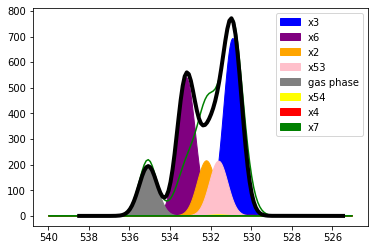

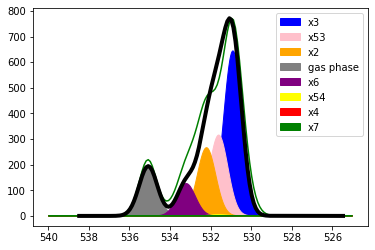

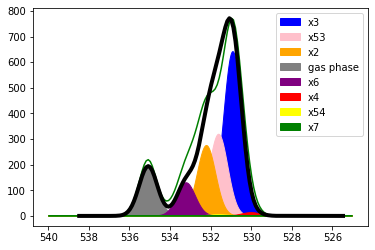

In [17]:
sols[55].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[49].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)

## Between Integral Difference Comparison

In [14]:
integrals_list = []
for i in range(len(default_rxn_consts)):
    integrals_list.append([])
    for j in range(5):
        integrals_list[i].append(sols[i*5 + j].integral_diff_between())
integral_diffs = pd.DataFrame(integrals_list, columns=['0.1', '0.5', '1', '5', '10'])
integral_diffs

,0.1,0.5,1,5,10
0,310.463710,331.190608,334.062083,336.392300,336.684848
1,507.535663,336.185130,334.062083,584.056733,698.564322
2,336.304743,333.088562,334.062083,334.894234,335.002174
3,335.002244,334.576553,334.062083,333.163150,336.304616
4,369.447624,351.621773,334.062083,276.927464,302.322010
5,335.054136,334.613433,334.062083,329.704924,324.370110
6,626.213126,368.157133,334.062083,432.531271,451.795975
7,422.066457,371.145596,334.062083,509.648222,594.603158
8,474.122504,379.353061,334.062083,421.279007,485.486746
9,335.765902,335.005491,334.062083,326.683914,317.855487


In [15]:
integral_diffs_min = integral_diffs.agg(['min', 'idxmin']).T
integral_diffs_min

,min,idxmin
0.1,310.463710,0.0
0.5,236.581488,11.0
1,334.062083,0.0
5,276.927464,4.0
10,302.322010,4.0


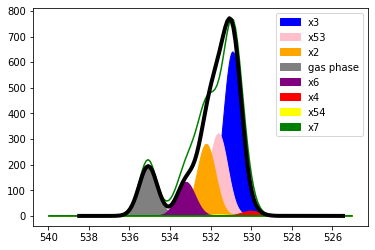

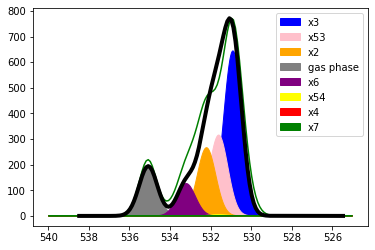

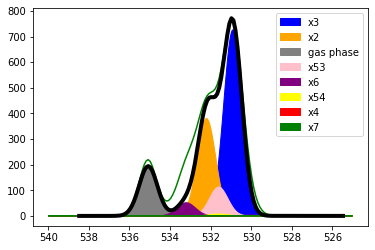

In [17]:
sols[0].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[24].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)

## Peak Comparison

In [26]:
real_max_arg = signal.argrelmax(np.array(sols[0].xps.intensity))
print(real_max_arg)
print(np.array(sols[0].xps.binding_energy)[real_max_arg])
real_peak = 531.2

(array([34, 75]),)
[535.075 530.975]


In [34]:
peaks_list = []
for i in range(len(default_rxn_consts)):
    peaks_list.append([])
    for j in range(5):
        s = sols[i*5 + j]
        max_arg = signal.argrelmax(np.array(s.envelope))
        bes = s.resampled_binding_energies[max_arg]
        print('max arg:', max_arg)
        print('max binding energy:', bes)
        if len(bes) == 2:
            peaks_list[i].append(abs(bes[0] - real_peak))
        else:
            peaks_list[i].append(1)    
        
peaks = pd.DataFrame(peaks_list, columns=['0.1', '0.5', '1', '5', '10'])

max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([54, 96]),)
max binding energy: [530.875 535.075]
max arg: (array([55, 96]),)
max binding energy: [530.975 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([61, 96]),)
max binding energy: [531.575 535.075]
max arg: (array([61, 96]),)
max binding energy: [531.575 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (array([56, 96]),)
max binding energy: [531.075 535.075]
max arg: (

In [35]:
peaks

,0.1,0.5,1,5,10
0,0.125,0.125,0.125,0.125,0.125
1,0.325,0.225,0.125,0.375,0.375
2,0.125,0.125,0.125,0.125,0.125
3,0.125,0.125,0.125,0.125,0.125
4,0.125,0.125,0.125,0.225,1.000
5,0.125,0.125,0.125,0.125,0.125
6,1.000,0.125,0.125,1.000,1.000
7,1.000,0.125,0.125,1.000,1.000
8,0.175,0.025,0.125,0.225,0.225
9,0.125,0.125,0.125,0.125,0.125


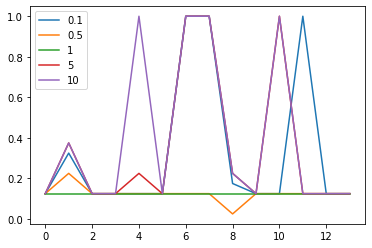

In [36]:
peaks.plot()

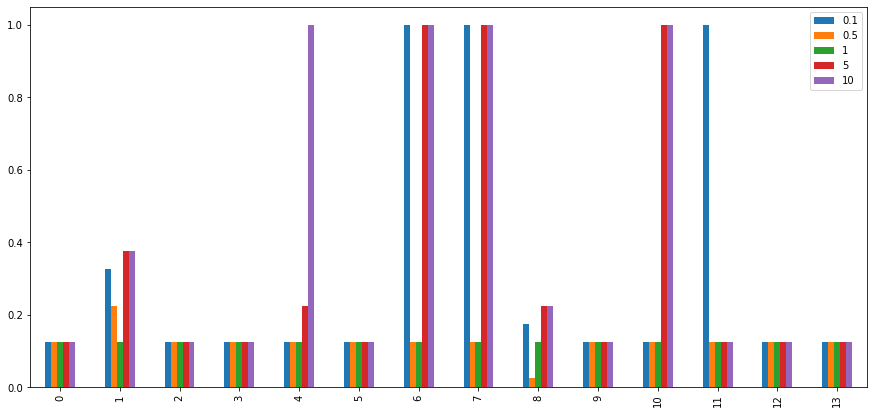

In [37]:
peaks.plot.bar(figsize=(15,7))

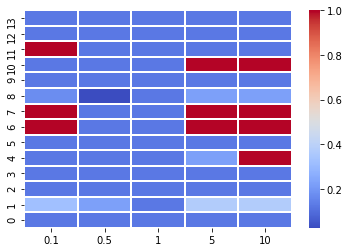

In [38]:
peaks_heatmap = sb.heatmap(peaks, cmap='coolwarm', linewidths=1)
peaks_heatmap.invert_yaxis()

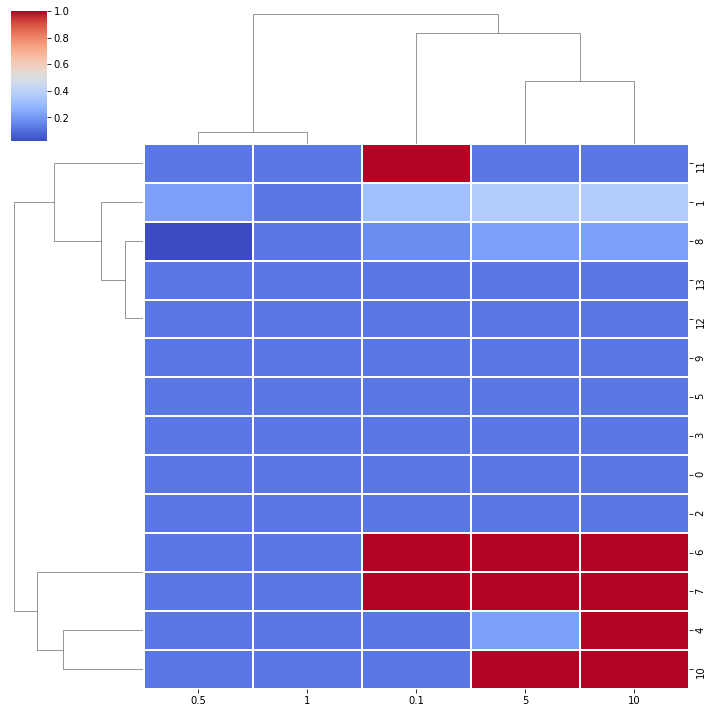

In [39]:
peaks_clustermap = sb.clustermap(peaks, cmap='coolwarm', linewidths=1)

Equations 0, 2, 3, 4, 9 , 12, 13 have the least impact on the overall system. Changes to their constant values barely affect their respective RMSEs and peak locations.

In [33]:
sols[50].names
sols[50].final_state().items()

dict_items([(x4, 0.0008887649064402507), (x7, -5.420061535783056e-07), (y1, 0.4221553858748809), (x2, 0.13928093272576714), (x3, 0.3116576906553475), (x6, 0.007904534617648933), (x53, 0.17364229306062323), (x54, 0.002510059938005285)])

## Various testing types

In [7]:
rmse_integral_list = []
for i in range(len(default_rxn_consts)):
    rmse_integral_list.append([])
    for j in range(5):
        rmse_integral_list[i].append(sols[i*5 + j].rmse()**2 / sols[i*5 + j].envelope_integral())
rmse_integral_diffs = pd.DataFrame(rmse_integral_list, columns=['0.1', '0.5', '1', '5', '10'])
rmse_integral_diffs

,0.1,0.5,1,5,10
0,0.904791,1.033860,1.053668,1.070196,1.072298
1,3.596286,1.365474,1.053668,4.513106,7.453499
2,1.075736,1.042839,1.053668,1.065951,1.067738
3,1.067739,1.060942,1.053668,1.034401,1.075735
4,1.352778,1.186486,1.053668,0.949379,1.124732
5,1.060932,1.057696,1.053668,1.022827,0.987400
6,4.276297,1.259717,1.053668,2.772993,3.271089
7,2.531414,1.555054,1.053668,2.956171,3.851782
8,2.605677,1.439271,1.053668,2.253566,3.210299
9,1.065713,1.060307,1.053668,1.004026,0.949857


In [9]:
rmse_integral_diffs_min = rmse_integral_diffs.agg(['min', 'idxmin']).T
rmse_integral_diffs_min

,min,idxmin
0.1,0.022465,0.0
0.5,0.017754,11.0
1,0.024508,0.0
5,0.023381,10.0
10,0.023101,9.0


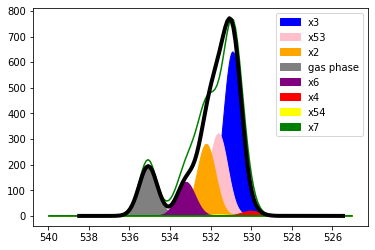

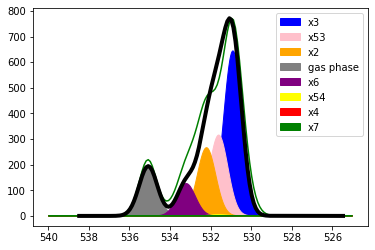

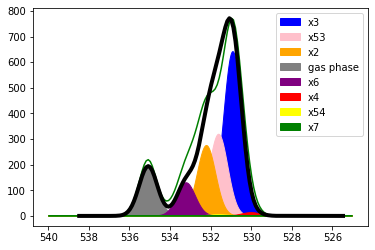

In [11]:
sols[0].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[49].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)